In [70]:
import gspread
import pandas as pd 
from oauth2client.service_account import ServiceAccountCredentials
import numpy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

credentials = {
}

scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_dict(credentials, scope)
client = gspread.authorize(creds)

In [71]:
sheet = client.open("IoT Cloud")

home_sheet = sheet.worksheet("Home")
door_sheet = sheet.worksheet("Door")
weather_sheet = sheet.worksheet("Weather")

In [72]:
home = pd.DataFrame(home_sheet.get_all_values())
home.columns = ["Year", "Month", "Day", "Hour", "Minute", "Home State", "Timestamp"]
home = home.sort_values(by='Timestamp')
print(' start ', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(home['Timestamp'].iloc[0]))))

home['Timestamp'] = pd.to_datetime(home['Timestamp'], unit ='s') # convert column to datetime object
home['Timestamp'] = home['Timestamp'].dt.floor('min')
home = home.set_index(home['Timestamp'])
home = home.drop(columns=["Year", "Month", "Day", "Minute", "Hour", "Timestamp"])


weather = pd.DataFrame(weather_sheet.get_all_values())
weather.columns = ["Year", "Month", "Day", "Hour", "Minute", "Temperature", "Conditon", "Timestamp"]
weather = weather.sort_values(by='Timestamp')

weather['Timestamp'] = pd.to_datetime(weather['Timestamp'], unit ='s') # convert column to datetime object
weather['Timestamp'] = weather['Timestamp'].dt.floor('min')
weather = weather.set_index(weather['Timestamp'])
weather = weather.drop(columns=["Year", "Month", "Day", "Hour", "Minute", "Timestamp"])

 start  2021-12-07 00:01:53


In [73]:
w = weather.loc['2021-12-07':'2021-12-10']
h = home.loc['2021-12-07':'2021-12-10']
h= h.astype(str).astype(int)


In [74]:
w = w.resample('T').pad()
w.tail()

,Temperature,Conditon
Timestamp,,
2021-12-10 23:26:00,3.42,Clear
2021-12-10 23:27:00,3.42,Clear
2021-12-10 23:28:00,3.42,Clear
2021-12-10 23:29:00,3.42,Clear
2021-12-10 23:30:00,2.76,Clear


In [75]:
hh = h.resample('H').sum()
hh.head()

,Home State
Timestamp,
2021-12-07 00:00:00,29
2021-12-07 01:00:00,33
2021-12-07 02:00:00,28
2021-12-07 03:00:00,21
2021-12-07 04:00:00,30


In [76]:
hh["Home State"] = (hh["Home State"] > 0).astype(int)

hh.head()

,Home State
Timestamp,
2021-12-07 00:00:00,1
2021-12-07 01:00:00,1
2021-12-07 02:00:00,1
2021-12-07 03:00:00,1
2021-12-07 04:00:00,1


In [77]:
merge=pd.merge(h,w, how='inner', left_index=True, right_index=True)
merge["Home State"] = merge["Home State"].astype(str).astype(int)
merge["Temperature"] = merge["Temperature"].astype(str).astype(float)

In [78]:
merge.head()

,Home State,Temperature,Conditon
Timestamp,,,
2021-12-07 00:21:00,0,2.76,Clouds
2021-12-07 00:22:00,1,2.76,Clouds
2021-12-07 00:24:00,1,2.76,Clouds
2021-12-07 00:25:00,1,2.76,Clouds
2021-12-07 00:26:00,1,2.76,Clouds


In [79]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5067 entries, 2021-12-07 00:21:00 to 2021-12-10 23:30:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Home State   5067 non-null   int64  
 1   Temperature  5067 non-null   float64
 2   Conditon     5067 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 158.3+ KB


In [80]:
from sklearn.model_selection import train_test_split

train, other = train_test_split(merge, test_size=0.2, random_state=0)

test, validation = train_test_split(other, test_size=0.5, random_state=0)

print('The sizes for train, test, and validation should be {}'.format((len(train), len(validation), len(test))))

The sizes for train, test, and validation should be (4053, 507, 507)


In [29]:
#BALANCING DATASET 

import pandas as pd
from sklearn.linear_model import LogisticRegression
 
total = len(train)
print(total)
nb_pos = train['Home State'].sum()
print(nb_pos)
nb_neg = total - nb_pos
print(nb_neg)
 

home_true = train.loc[train['Home State'] == 1]
home_false = train.loc[train['Home State'] == 0].sample(nb_pos)
TrainBalanced= pd.concat((home_true, home_false))

len(TrainBalanced) 

#### Home Balanced

5135
1728
3407


3456

In [105]:
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score,precision_score,recall_score

class ModelSummary:
    """ This class extracts a summary of the model
    
    Methods
    -------
    get_se()
        computes standard error
    get_ci(SE_est)
        computes confidence intervals
    get_pvals()
        computes p-values
    get_summary(name=None)
        prints the summary of the model
    """
    
    def __init__(self, clf, X, y):
        """
        Parameters
        ----------
        clf: class
            the classifier object model
        X: pandas Dataframe
            matrix of predictors
        y: numpy array
            matrix of variable
        """
        self.clf = clf
        self.X = X
        self.y = y
        pass
    
    def get_se(self):
        # from here https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients
        predProbs = self.clf.predict_proba(self.X)
        X_design = np.hstack([np.ones((self.X.shape[0], 1)), self.X])
        V = np.diagflat(np.product(predProbs, axis=1))
        covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
        return np.sqrt(np.diag(covLogit))

    def get_ci(self, SE_est):
        """
        Parameters
        ----------
        SE_est: numpy array
            matrix of standard error estimations
        """
        p = 0.975
        df = len(self.X) - 2
        crit_t_value = stats.t.ppf(p, df)
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        upper = coefs + (crit_t_value * SE_est)
        lower = coefs - (crit_t_value * SE_est)
        cis = np.zeros((len(coefs), 2))
        cis[:,0] = lower
        cis[:,1] = upper
        return cis
    
    def get_pvals(self):
        # from here https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
        p = self.clf.predict_proba(self.X)
        n = len(p)
        m = len(self.clf.coef_[0]) + 1
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        se = self.get_se()
        t =  coefs/se  
        p = (1 - stats.norm.cdf(abs(t))) * 2
        return p
    
    def get_summary(self, names=None):
        ses = self.get_se()
        cis = self.get_ci(ses)
        lower = cis[:, 0]
        upper = cis[:, 1]
        pvals = self.get_pvals()
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        data = []
        for i in range(len(coefs)):
            currlist = []
            currlist.append(np.round(coefs[i], 3))
            currlist.append(np.round(ses[i], 3))
            currlist.append(np.round(pvals[i], 3))
            currlist.append(np.round(lower[i], 3))
            currlist.append(np.round(upper[i], 3))
            data.append(currlist)
        cols = ['coefficient', 'std', 'p-value', '[0.025', '0.975]']
        sumdf = pd.DataFrame(columns=cols, data=data)
        if names is not None:
            new_names = ['intercept']*(len(names) + 1)
            new_names[1:] = [i for i in names]
            sumdf.index = new_names
        else:
            try:
                names = list(self.X.columns)
                new_names = ['intercept']*(len(names) + 1)
                new_names[1:] = [i for i in names]
                sumdf.index = new_names
            except:
                pass
        print(sumdf)
        acc = (accuracy_score(self.y, self.clf.predict(self.X)) + recall_score(self.y, self.clf.predict(self.X)))/2
        #acc = accuracy_score(self.y, self.clf.predict(self.X))
        confmat = confusion_matrix(self.y, self.clf.predict(self.X))
        print('-'*60)
        print('Confusion Matrix (total:{}) \t Accuracy: \t  {}'.format(len(self.X),np.round(acc, 3)))
        print('  TP: {} | FN: {}'.format(confmat[1][1],confmat[1][0]))
        print('  FP: {} | TN: {}'.format(confmat[0][1],confmat[0][0]))

In [109]:
#Random Select

import warnings
warnings.filterwarnings("ignore")

w = weather.loc[:'2021-12-10']
h = home.loc[:'2021-12-10']
h= h.astype(str).astype(int)


merge=pd.merge(h,w, how='inner', left_index=True, right_index=True)
merge["Home State"] = merge["Home State"].astype(str).astype(int)
merge["Temperature"] = merge["Temperature"].astype(str).astype(float)

merge = merge.drop('Conditon', 1)

train, other = train_test_split(merge, test_size=0.2, random_state=0)
test, validation = train_test_split(other, test_size=0.5, random_state=0)

total = len(train)
nb_pos = train['Home State'].sum()
nb_neg = total - nb_pos
 
home_true = train.loc[train['Home State'] == 1]
home_false = train.loc[train['Home State'] == 0].sample(nb_pos)
TrainBalanced= pd.concat((home_true, home_false))

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score
import numpy as np
import pandas as pd
 
X_train_unstandard = train.drop(columns='Home State')
X_train=(X_train_unstandard-X_train_unstandard.mean())/X_train_unstandard.std()
y_train = train['Home State']

X_val_unstandard = validation.drop(columns='Home State')
X_val= (X_val_unstandard - X_val_unstandard.mean())/X_val_unstandard.std()
y_val = validation['Home State']

X_test_unstandard = test.drop(columns='Home State')
X_test= (X_test_unstandard - X_test_unstandard.mean())/X_test_unstandard.std()
y_test = test['Home State']

model = LogisticRegression(C=1e9).fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
y_val_predicted = model.predict(X_val)
y_test_predicted = model.predict(X_test)

training_acc = (accuracy_score(y_train, y_train_predicted) + recall_score(y_train, y_train_predicted))/2
weighted_acc = (accuracy_score(y_val, y_val_predicted) + recall_score(y_val, y_val_predicted))/2
test_acc = (accuracy_score(y_test, y_test_predicted) + recall_score(y_test, y_test_predicted))/2

print('======= Accuracy  table =======')
print('Training recall is:    {}'.format(recall_score(y_train, y_train_predicted)))
print('Validation recall is:  {}'.format(recall_score(y_val, y_val_predicted)))
print('Validation accuracy is:  {}'.format(accuracy_score(y_val, y_val_predicted)))
print('precision accuracy is:  {}'.format(precision_score(y_val, y_val_predicted)))
print('training weighted accuracy is:  {}'.format(training_acc))
print('validation weighted accuracy is:  {}'.format(weighted_acc))
print('test weighted accuracy is:    {}'.format(test_acc))


======= Accuracy  table =======
Training recall is:    0.15
Validation recall is:  0.0
Validation accuracy is:  0.7777777777777778
precision accuracy is:  0.0
training weighted accuracy is:  0.43529411764705883
validation weighted accuracy is:  0.3888888888888889
test weighted accuracy is:    0.6875


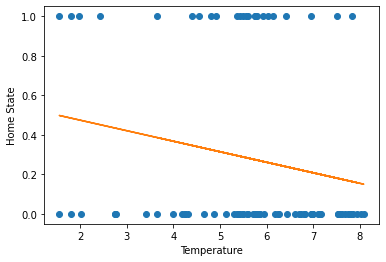

In [115]:
from sklearn.linear_model import LinearRegression as lr

xlab = 'Temperature'
ylab = 'Home State'

X = merge[xlab].values.reshape(-1, 1)
y = merge[ylab].values.reshape(-1, 1)
linearModel = lr()
linearModel.fit(X, y)

# extracting model parameters
a = linearModel.coef_[0][0]
b = linearModel.intercept_[0]

y_predicted = a * X + b  # calculating the line of best fit

plt.plot(merge[xlab], merge[ylab], linestyle='', marker='o')  # plotting the raw data
plt.plot(merge[xlab], y_predicted)  # plotting 
plt.xlabel('{}'.format(xlab))
plt.ylabel('{}'.format(ylab))
plt.show()


In [62]:
merge = merge.apply(lambda x: pd.Series(x.dropna().values))


In [63]:
X_train

,Temperature
Timestamp,
2021-12-14 21:00:00,1.006050
2021-12-13 02:00:00,0.962467
2021-12-12 10:00:00,1.180379
2021-12-07 22:00:00,-0.718571
2021-12-14 13:00:00,1.336031
...,...
2021-12-09 19:00:00,-0.513111
2021-12-15 00:00:00,0.738329
2021-12-11 21:00:00,0.492399


In [104]:
w = weather.loc[:'2021-12-10']
h = home.loc[:'2021-12-10']
h= h.astype(str).astype(int)

hh = h.resample('H').sum()
hh["Home State"] = (hh["Home State"] > 0).astype(int)
ww = w.resample('H').pad()


merge2=pd.merge(hh,ww, how='inner', left_index=True, right_index=True)
merge2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2021-12-07 00:00:00 to 2021-12-10 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Home State   96 non-null     int64  
 1   Temperature  96 non-null     float64
 2   Conditon     96 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.0+ KB


In [103]:
#RANDOM BALANCED

import warnings
warnings.filterwarnings("ignore")

w = weather.loc[:'2021-12-10']
h = home.loc[:'2021-12-10']
h= h.astype(str).astype(int)

hh = h.resample('H').sum()
hh["Home State"] = (hh["Home State"] > 0).astype(int)
ww = w.resample('H').pad()

merge2=pd.merge(hh,ww, how='inner', left_index=True, right_index=True)
merge2.head(20)

merge2=pd.merge(hh,ww, how='inner', left_index=True, right_index=True)
merge2["Home State"] = merge2["Home State"].astype(str).astype(int)
merge2["Temperature"] = merge2["Temperature"].astype(str).astype(float)

merge2 = merge2.replace({'Clear': 0}, regex=True)
merge2 = merge2.replace({'Cloud': 1}, regex=True)
merge2 = merge2.replace({'Rain': 2}, regex=True)

merge2 = merge2.drop('Conditon', 1)

train, other = train_test_split(merge2, test_size=0.2, random_state=0)
test, validation = train_test_split(other, test_size=0.5, random_state=0)

total = len(train)
nb_pos = train['Home State'].sum()
nb_neg = total - nb_pos
 
home_true = train.loc[train['Home State'] == 1]
home_false = train.loc[train['Home State'] == 0].sample(nb_pos)
TrainBalanced= pd.concat((home_true, home_false))
 
X_train_unstandard = train.drop(columns='Home State')
X_train=(X_train_unstandard-X_train_unstandard.mean())/X_train_unstandard.std()
y_train = train['Home State']

X_val_unstandard = validation.drop(columns='Home State')
X_val= (X_val_unstandard - X_val_unstandard.mean())/X_val_unstandard.std()
y_val = validation['Home State']

X_test_unstandard = test.drop(columns='Home State')
X_test= (X_test_unstandard - X_test_unstandard.mean())/X_test_unstandard.std()
y_test = test['Home State']

model = LogisticRegression(C=1e9).fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
y_val_predicted = model.predict(X_val)
y_test_predicted = model.predict(X_test)

training_acc = (accuracy_score(y_train, y_train_predicted) + recall_score(y_train, y_train_predicted))/2
weighted_acc = (accuracy_score(y_val, y_val_predicted) + recall_score(y_val, y_val_predicted))/2
test_acc = (accuracy_score(y_test, y_test_predicted) + recall_score(y_test, y_test_predicted))/2

print('======= Accuracy  table =======')
print('Training recall is:    {}'.format(recall_score(y_train, y_train_predicted)))
print('Validation recall is:  {}'.format(recall_score(y_val, y_val_predicted)))
print('Validation accuracy is:  {}'.format(accuracy_score(y_val, y_val_predicted)))
print('precision accuracy is:  {}'.format(precision_score(y_val, y_val_predicted)))
print('training weighted accuracy is:  {}'.format(training_acc))
print('validation weighted accuracy is:  {}'.format(weighted_acc))
print('test weighted accuracy is:    {}'.format(test_acc))


======= Accuracy  table =======
Training recall is:    0.5
Validation recall is:  0.5
Validation accuracy is:  0.7
precision accuracy is:  1.0
training weighted accuracy is:  0.5526315789473684
validation weighted accuracy is:  0.6
test weighted accuracy is:    0.5142857142857142


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Home')]

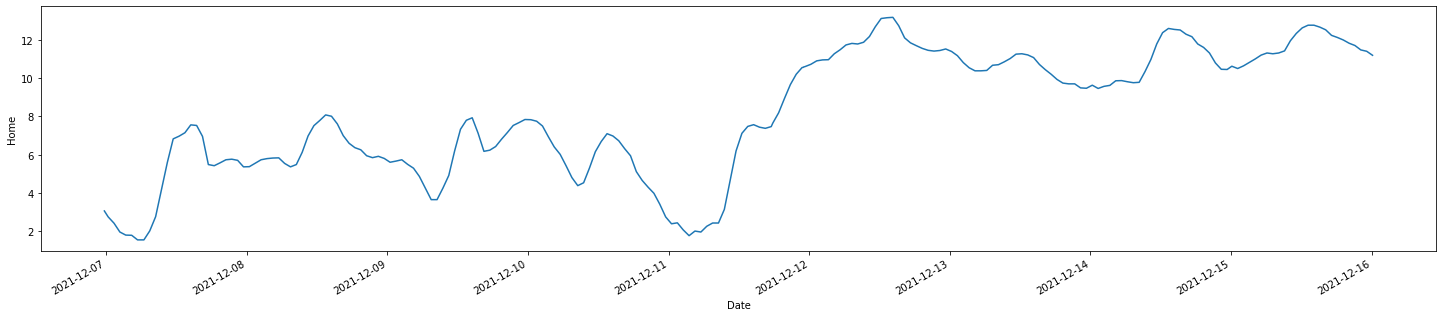

In [84]:
wplot = weather
wplot['Temperature']=wplot['Temperature'].astype(str).astype(float)
wplot['Temperature'].plot(figsize=(25,5)).set(xlabel='Date', ylabel='Home')


[Text(0.5, 0, 'Time (24h)'), Text(0, 0.5, 'Degrees (C)')]

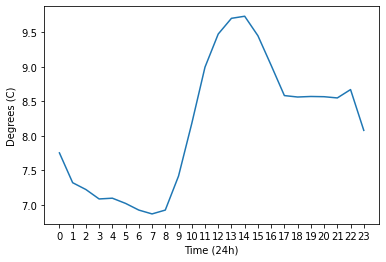

In [116]:
wplot.groupby(wplot.index.hour).mean()['Temperature'].plot(xticks=np.arange(24)).set(xlabel='Time (24h)', ylabel='Degrees (C)')

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Home')]

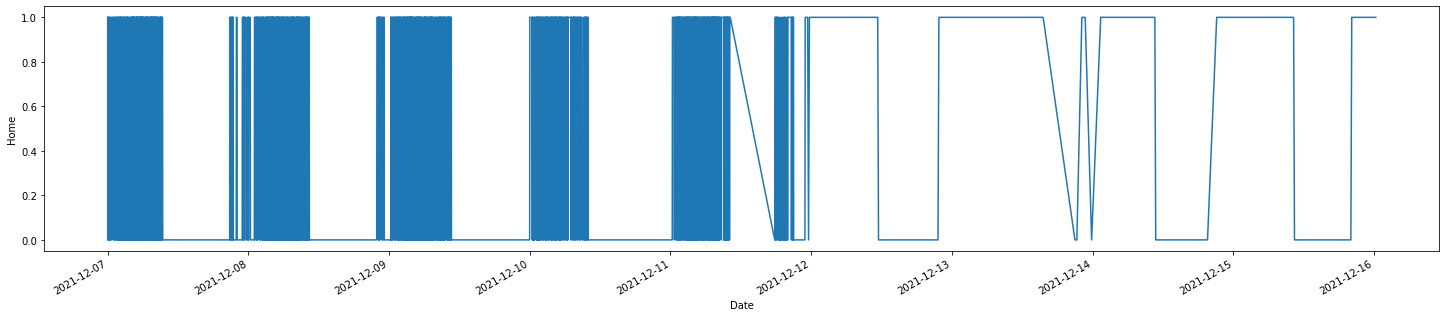

In [39]:
h = home.astype(float)
h['Home State'].plot(figsize=(25,5)).set(xlabel='Date', ylabel='Home')

In [88]:
#SINGLE VECTOR UNBALNCED single

import warnings
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

merge2=pd.merge(hh,ww, how='inner', left_index=True, right_index=True)
merge2["Home State"] = merge2["Home State"].astype(str).astype(int)
merge2["Temperature"] = merge2["Temperature"].astype(str).astype(float)

merge2 = merge2.replace({'Clear': 0}, regex=True)
merge2 = merge2.replace({'Cloud': 1}, regex=True)
merge2 = merge2.replace({'Rain': 2}, regex=True)

# merge2 = merge2.drop('Conditon', 1)

train, other = train_test_split(merge2, test_size=0.2, random_state=0)
test, validation = train_test_split(other, test_size=0.5, random_state=0)

X_train_unstandard = train.drop(columns='Home State')
X_train=(X_train_unstandard-X_train_unstandard.mean())/X_train_unstandard.std()
y_train = train['Home State']

X_val_unstandard = validation.drop(columns='Home State')
X_val= (X_val_unstandard - X_val_unstandard.mean())/X_val_unstandard.std()
y_val = validation['Home State']

X_test_unstandard = test.drop(columns='Home State')
X_test= (X_test_unstandard - X_test_unstandard.mean())/X_test_unstandard.std()
y_test = test['Home State']

model = SVC(C=1, kernel = 'linear', gamma = 0.005) 
model = model.fit(X_train, y_train)

ypred = model.predict(X_val)

training_acc = (accuracy_score(y_train, y_train_predicted) + recall_score(y_train, y_train_predicted))/2
weighted_acc = (accuracy_score(y_val, y_val_predicted) + recall_score(y_val, y_val_predicted))/2
test_acc = (accuracy_score(y_test, y_test_predicted) + recall_score(y_test, y_test_predicted))/2

print('======= Accuracy  table =======')
print('Training recall is:    {}'.format(recall_score(y_train, y_train_predicted)))
print('Validation recall is:  {}'.format(recall_score(y_val, y_val_predicted)))
print('Validation accuracy is:  {}'.format(accuracy_score(y_val, y_val_predicted)))
print('precision accuracy is:  {}'.format(precision_score(y_val, y_val_predicted)))
print('training weighted accuracy is:  {}'.format(training_acc))
print('validation weighted accuracy is:  {}'.format(weighted_acc))
print('test weighted accuracy is:    {}'.format(test_acc))

======= Accuracy  table =======
Training recall is:    0.5555555555555556
Validation recall is:  0.5
Validation accuracy is:  0.7
precision accuracy is:  1.0
training weighted accuracy is:  0.5935672514619883
validation weighted accuracy is:  0.6
test weighted accuracy is:    0.5142857142857142
